In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from matplotlib.animation import FuncAnimation
from adjustText import adjust_text   
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import folium

# # Define the URL
url = 'https://data.smartdublin.ie/dublinbikes-api/historical/'

# Get the current datetime
now = datetime.utcnow()

# Create an empty DataFrame to store the data
df = pd.DataFrame()

# Iterate through each hour in the last 14 days (24 hours * 14 days)
for i in range(24 * 14):
    # Calculate the datetime string for the initial datetime of each hour-long period
    init_datetime_str = (now - timedelta(hours=i)).strftime('%Y-%m-%d %H:%M:%S')
    
    # Define the parameters for the request
    params = {'init': init_datetime_str}
    
    # Send the GET request
    response = requests.get(url, params=params)
    
    # Check for a successful response
    if response.status_code == 201:
        # Parse the JSON response to a DataFrame
        data = response.json()
        hourly_df = pd.DataFrame(data)
        # Append the data to the DataFrame
        df = pd.concat([df, hourly_df], ignore_index=True)
    else:
        print(f'Failed to retrieve data for {init_datetime_str}: {response.status_code}')
        


In [2]:
# Data checking
address_count_per_harvest_time = df.groupby('harvest_time')['address'].nunique()

# Filter rows that are not equal to 114
non_114_rows = address_count_per_harvest_time[address_count_per_harvest_time != 114]

if len(non_114_rows) > 0:
    print("The following harvest_time values do not have 114 addresses:")
    print(non_114_rows)
else:
    print("All harvest_time values have 114 addresses.")
    
# All harvest_time values have 114 addresses. Looks good! Every harvest time has the total number of addresses. I was concerned there might have been data leaks.

All harvest_time values have 114 addresses.


In [3]:
# Data cleansing/updating

# Time columns updating
df['last_update'] = pd.to_datetime(df['last_update'])
df['hour'] = df['last_update'].dt.hour
df['date_hour'] = df['last_update'].dt.strftime('%Y-%m-%d %H')
df['day_of_week'] = df['last_update'].dt.day_name()


# Time columns updating
df['harvest_time'] = pd.to_datetime(df['harvest_time'])
df['hour_ht'] = df['harvest_time'].dt.hour
df['date_hour_ht'] = df['last_update'].dt.strftime('%Y-%m-%d %H')


# Add a column for weekdays and weekends
df['day_type'] = df['last_update'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# sub_df = df[['day_of_week', 'date_hour', 'hour', 'last_update', 'address', 'available_bikes', 'bike_stands', 'latitude', 'longitude']]
df['capacity_ratio'] = df['available_bikes'] / df['bike_stands']

# saving locally as API takes time, better to retreieve from here
df.to_csv('dublin_bike_latest.csv')


In [4]:
df = pd.read_csv('dublin_bike_csv.csv')

mon_sub_df = df[df['day_of_week'] == "Monday"]

# Group by 'address' and calculate the standard deviation for 'capacity_ratio'
std_dev = mon_sub_df.groupby('address')['capacity_ratio'].agg(['std']).reset_index()

# Rename the 'std' column to 'capacity_ratio_std' to make it clearer
std_dev.rename(columns={'std': 'capacity_ratio_std'}, inplace=True)

# Sort the data by standard deviation in descending order and select the top 10
top_10_std_dev = std_dev.sort_values(by='capacity_ratio_std', ascending=False).head(10)
top_10_std_dev_desc = std_dev.sort_values(by='capacity_ratio_std', ascending=True).head(10)


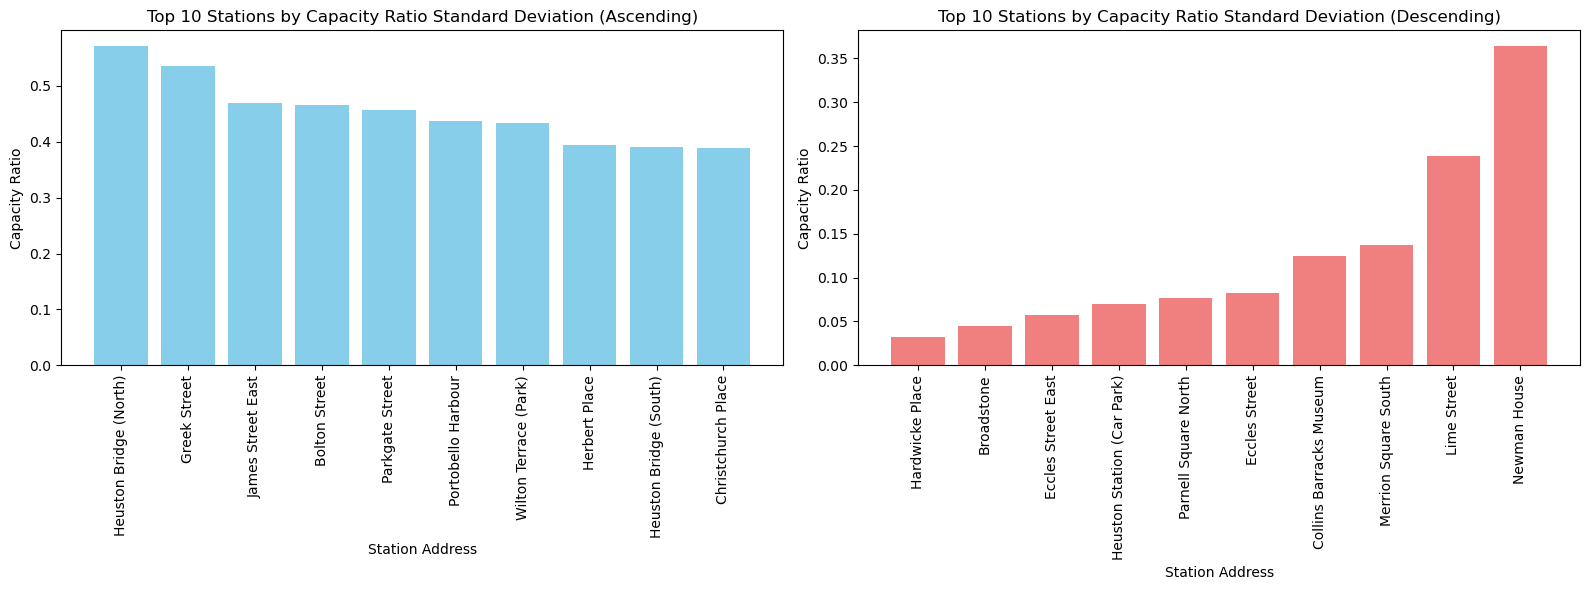

In [5]:
# Group by 'address' and calculate the total available bikes and bike stands for each station
sub_df_address_group = mon_sub_df.groupby(['address']).agg({'available_bikes': 'sum', 'bike_stands': 'sum'}).reset_index()

# Calculate the capacity ratio for each station
sub_df_address_group['capacity_ratio'] = sub_df_address_group['available_bikes'] / sub_df_address_group['bike_stands']

# Get the addresses of the top 10 stations by capacity ratio (ascending)
top_10_addresses = top_10_std_dev['address'].tolist()

# Create a subset of sub_df for the top 10 stations (ascending)
top_10_subset = sub_df_address_group[sub_df_address_group['address'].isin(top_10_addresses)]

# Order data in desc format
top_10_subset = top_10_subset.sort_values(by='capacity_ratio', ascending=False)

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotting the top 10 stations by capacity ratio (ascending) in the first subplot
axes[0].bar(top_10_subset['address'], top_10_subset['capacity_ratio'], color='skyblue')
axes[0].set_title('Top 10 Stations by Capacity Ratio Standard Deviation (Ascending)')
axes[0].set_ylabel('Capacity Ratio')
axes[0].set_xlabel('Station Address')
axes[0].tick_params(axis='x', rotation=90, labelrotation=90)

# Get the addresses of the top 10 stations by capacity ratio (descending)
top_10_addresses_desc = top_10_std_dev_desc['address'].tolist()

# Create a subset of sub_df for the top 10 stations (descending)
top_10_subset_desc = sub_df_address_group[sub_df_address_group['address'].isin(top_10_addresses_desc)]
top_10_subset_desc = top_10_subset_desc.sort_values(by='capacity_ratio', ascending=True)


# Plotting the top 10 stations by capacity ratio (descending) in the second subplot
axes[1].bar(top_10_subset_desc['address'], top_10_subset_desc['capacity_ratio'], color='lightcoral')
axes[1].set_title('Top 10 Stations by Capacity Ratio Standard Deviation (Descending)')
axes[1].set_ylabel('Capacity Ratio')
axes[1].set_xlabel('Station Address')
axes[1].tick_params(axis='x', rotation=90, labelrotation=90)

# Adjust layout
plt.tight_layout()
plt.show()


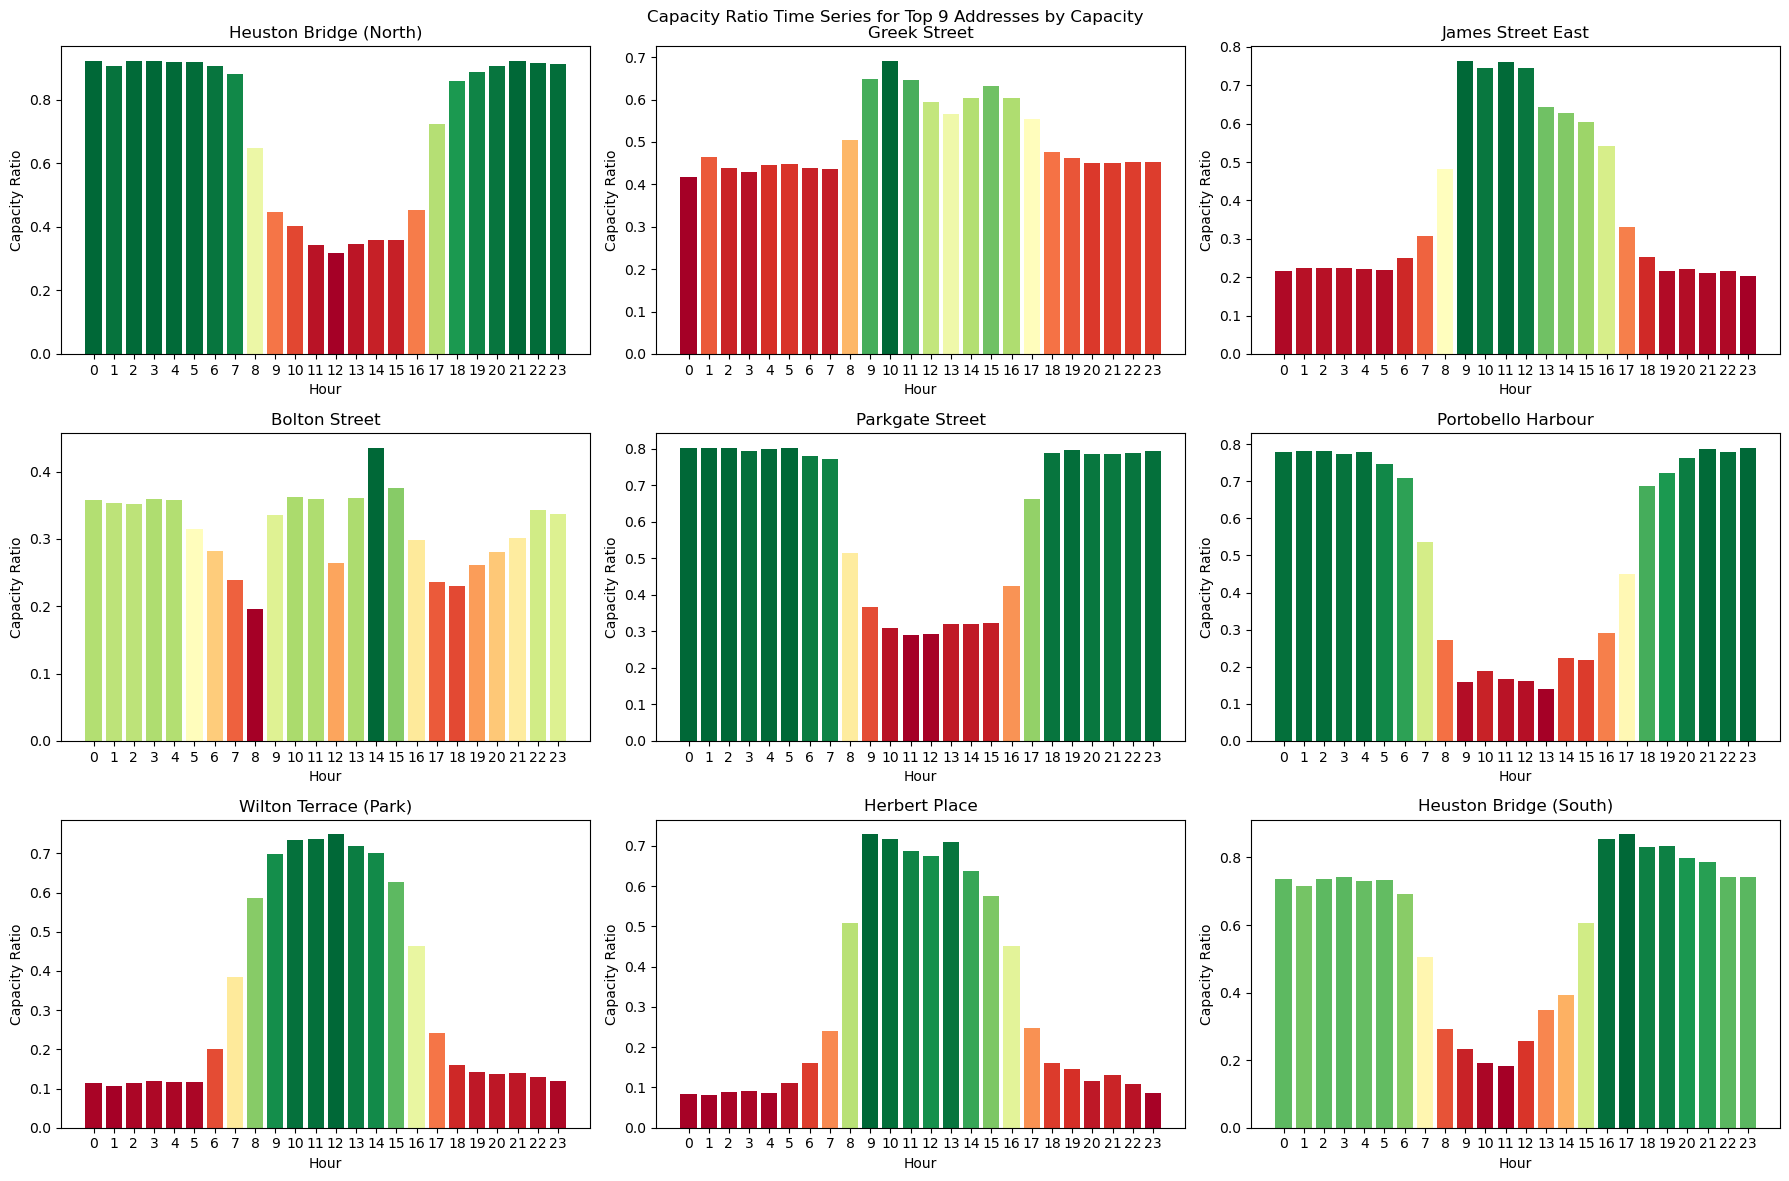

In [6]:
# get unique address list
top_10_addresses = list(top_10_subset['address'])

# Group by 'hour' and 'address' and aggregate sum
sub_df_hour = df.groupby(['hour', 'address']).agg({'available_bikes': 'sum', 'bike_stands': 'sum'}).reset_index()

# Calculate 'capacity_ratio' for sub_df_hour
sub_df_hour['capacity_ratio'] = sub_df_hour['available_bikes'] / sub_df_hour['bike_stands']

# Filter to only include addresses from top_10_addresses
sub_df_hour_top_10 = sub_df_hour[sub_df_hour['address'].isin(top_10_addresses)]


fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Capacity Ratio Time Series for Top 9 Addresses by Capacity')  # Update the title

# Using a colormap that transitions from red to yellow to green
cmap = plt.cm.RdYlGn

# Loop through the top 9 addresses
for i, address in enumerate(top_10_addresses[:-1]):  # Exclude the 10th address
    ax = axes[i//3, i%3]
    data = sub_df_hour_top_10[sub_df_hour_top_10['address'] == address]
    
    min_ratio = data['capacity_ratio'].min()
    max_ratio = data['capacity_ratio'].max()
    
    # Normalize the capacity ratio for color mapping
    normalized_ratios = (data['capacity_ratio'] - min_ratio) / (max_ratio - min_ratio)
    
    # Bar plot for each address with gradient colors
    bar_colors = cmap(normalized_ratios)
    ax.bar(data['hour'], data['capacity_ratio'], color=bar_colors)
    
    ax.set_title(address)
    ax.set_xlabel('Hour')
    ax.set_ylabel('Capacity Ratio')

    # Set x-axis ticks and labels for each hour
    ax.set_xticks(data['hour'])
    ax.set_xticklabels(data['hour'])

# Remove any unused subplots (in case you have less than 9 addresses)
for i in range(len(top_10_addresses) - 1, 9):
    axes[i//3, i%3].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top space so the suptitle doesn't overlap
plt.show()

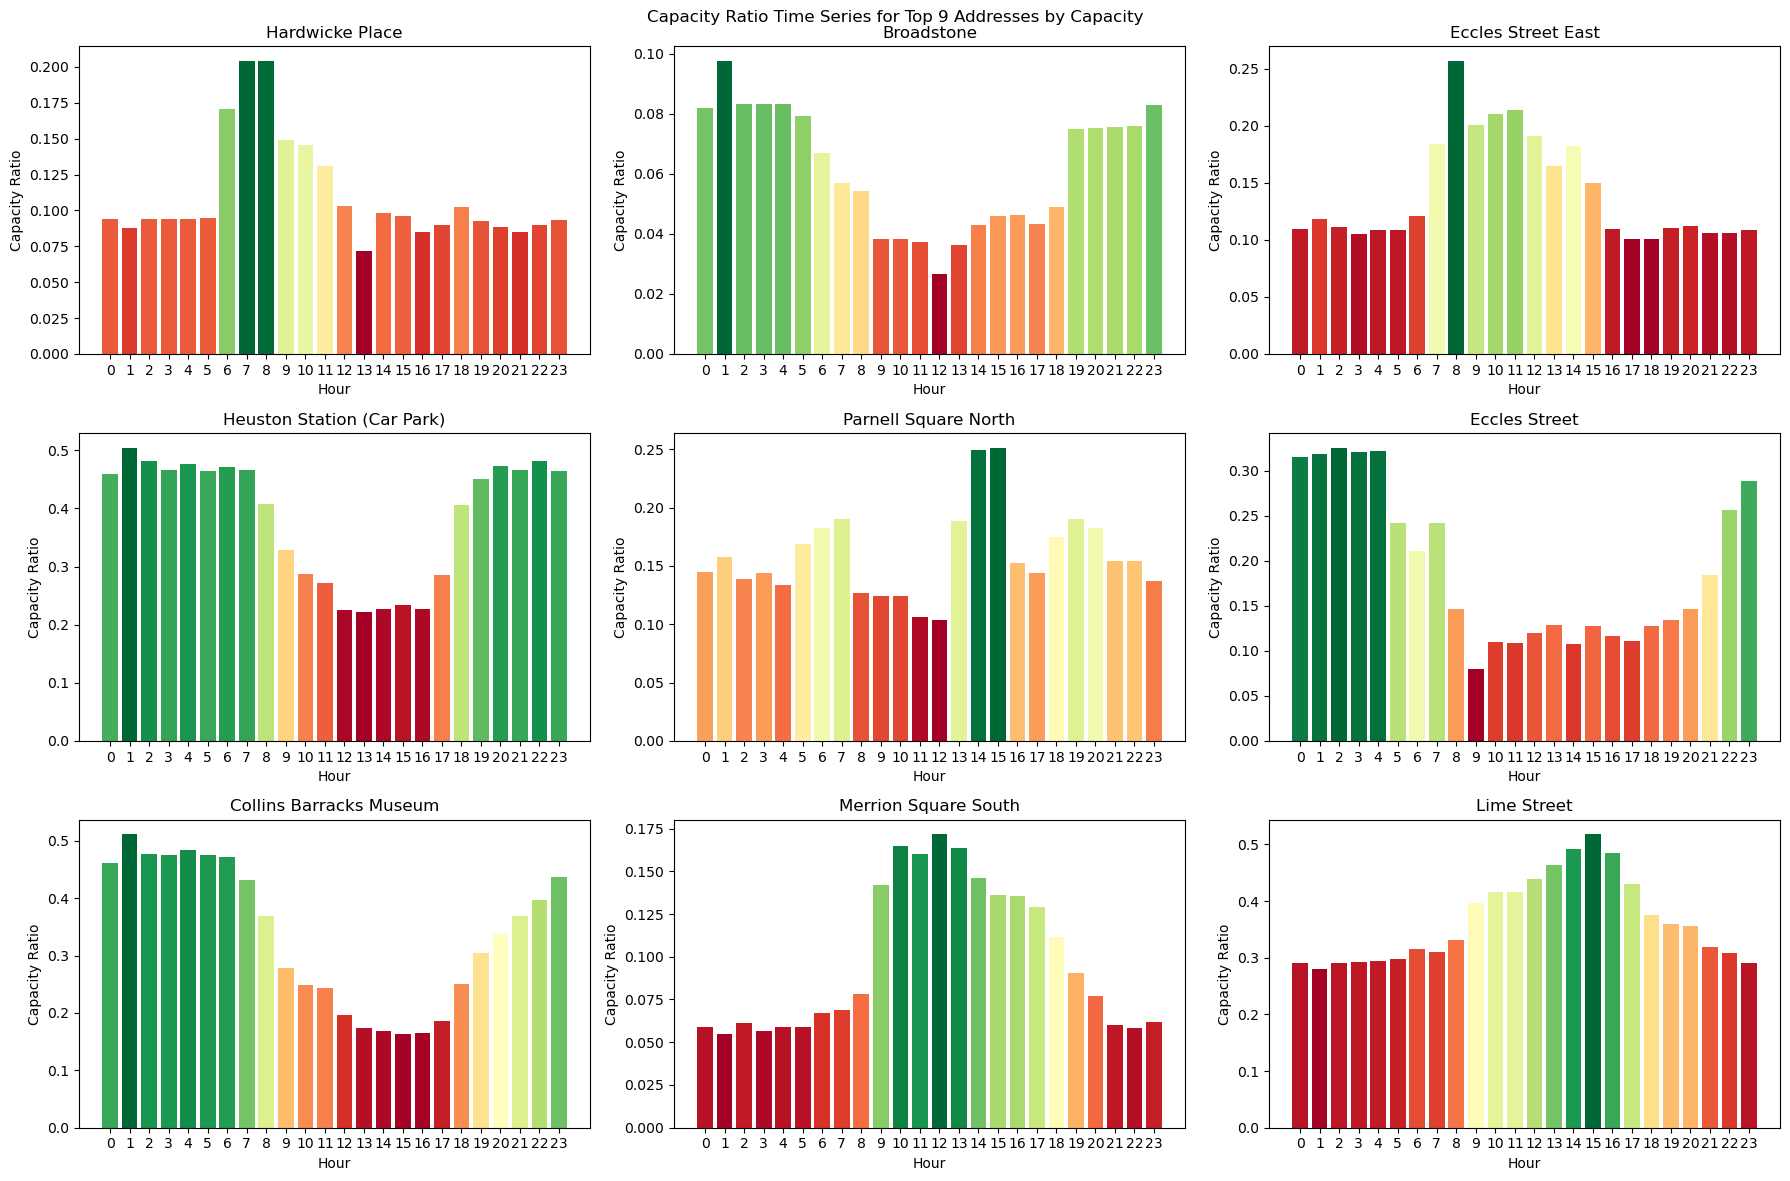

In [7]:
# get unique address list
top_10_addresses_desc = list(top_10_subset_desc['address'])

# Filter to only include addresses from top_10_addresses
sub_df_hour_top_10_desc = sub_df_hour[sub_df_hour['address'].isin(top_10_addresses_desc)]


fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Capacity Ratio Time Series for Top 9 Addresses by Capacity')  # Update the title

# Using a colormap that transitions from red to yellow to green
cmap = plt.cm.RdYlGn

# Loop through the top 9 addresses
for i, address in enumerate(top_10_addresses_desc[:-1]):  # Exclude the 10th address
    ax = axes[i//3, i%3]
    data = sub_df_hour_top_10_desc[sub_df_hour_top_10_desc['address'] == address]
    
    min_ratio = data['capacity_ratio'].min()
    max_ratio = data['capacity_ratio'].max()
    
    # Normalize the capacity ratio for color mapping
    normalized_ratios = (data['capacity_ratio'] - min_ratio) / (max_ratio - min_ratio)
    
    # Bar plot for each address with gradient colors
    bar_colors = cmap(normalized_ratios)
    ax.bar(data['hour'], data['capacity_ratio'], color=bar_colors)
    
    ax.set_title(address)
    ax.set_xlabel('Hour')
    ax.set_ylabel('Capacity Ratio')

    # Set x-axis ticks and labels for each hour
    ax.set_xticks(data['hour'])
    ax.set_xticklabels(data['hour'])

# Remove any unused subplots (in case you have less than 9 addresses)
for i in range(len(top_10_addresses) - 1, 9):
    axes[i//3, i%3].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top space so the suptitle doesn't overlap
plt.show()

In [8]:
def get_color(capacity_ratio):
    """Function to return color based on capacity ratio."""
    if capacity_ratio < 0.25:
        return 'red'
    elif capacity_ratio < 0.50:
        return 'orange'
    elif capacity_ratio < 0.75:
        return 'yellow'
    else:
        return 'green'

def plot_map_for_hour_and_day(sub_df, hour, day):
    # Filter data for the specific hour and day
    filtered_data = df[(df['hour'] == hour) & (sub_df['day_of_week'] == day)].copy()
    
    # Calculate average capacity ratio for that hour and day combo
    filtered_data['latitude'] = filtered_data['latitude'].astype(float)
    filtered_data['longitude'] = filtered_data['longitude'].astype(float)
    
    filtered_data = filtered_data.groupby(['latitude', 'longitude', 'address']).agg({'available_bikes': 'sum', 'bike_stands': 'sum'}).reset_index()
    filtered_data['capacity_ratio'] = filtered_data['available_bikes'] / filtered_data['bike_stands']

    # Create a base map
    m = folium.Map(location=[filtered_data['latitude'].mean(), filtered_data['longitude'].mean()], zoom_start=14)

    # Add stations to the map
    for _, row in filtered_data.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"{row['address']} - Capacity Ratio: {row['capacity_ratio']:.2f}",
            icon=folium.Icon(color=get_color(row['capacity_ratio'])),
        ).add_to(m)

    return m

# Example usage
plot_map_for_hour_and_day(df, 19, 'Monday')


C:\Users\admin\AppData\Local\Temp\ipykernel_13700\2754845560.py:31: UserWarning: color argument of Icon should be one of: {'red', 'purple', 'lightblue', 'blue', 'lightgray', 'darkpurple', 'darkred', 'darkblue', 'beige', 'white', 'lightred', 'black', 'orange', 'pink', 'cadetblue', 'gray', 'darkgreen', 'green', 'lightgreen'}.
  icon=folium.Icon(color=get_color(row['capacity_ratio'])),


In [9]:
from scipy.spatial import cKDTree

# Create a dataframe for the postal districts and their coordinates
postal_districts_data = {
    'Postal District': ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D6W', 'D07', 'D08', 'D09'],
    'Latitude': [53.353, 53.343, 53.361, 53.327, 53.383, 53.311, 53.309, 53.349, 53.337, 53.367],
    'Longitude': [-6.261, -6.255, -6.251, -6.235, -6.208, -6.257, -6.264, -6.279, -6.271, -6.246],
}

postal_districts_df = pd.DataFrame(postal_districts_data)

# Convert postal district coordinates to a k-d tree
postal_districts_tree = cKDTree(postal_districts_df[['Latitude', 'Longitude']].values)


# Find the nearest postal district for each bike station
distances, indices = postal_districts_tree.query(df[['latitude', 'longitude']].values)
df['postal_district'] = postal_districts_df.loc[indices, 'Postal District'].values


In [10]:
# Step 1: Create a subset
subset_df = df[['harvest_time', 'hour_ht', 'day_type', 'address', 'postal_district', 'available_bikes', 'latitude', 'longitude']].copy()

# Weekdays only
subset_df = subset_df[subset_df['day_type'] != 'Weekend']

# Step 2: Sort by address and then by harvest_time in descending order
subset_df.sort_values(by=['address', 'harvest_time'], ascending=[True, False], inplace=True)

# Step 3: Use the shift() method to get the previous available_bikes for each address
subset_df['previous_available_bikes'] = subset_df.groupby('address')['available_bikes'].shift(-1)

# Step 4: Calculate the rate of change
subset_df['rate_of_change'] = subset_df['available_bikes'] - subset_df['previous_available_bikes']

# Calculate bikes added and removed
subset_df['bikes_added'] = subset_df['rate_of_change'].apply(lambda x: x if x > 0 else 0)
subset_df['bikes_removed'] = subset_df['rate_of_change'].apply(lambda x: -x if x < 0 else 0)
subset_df['abs_rate_of_change'] = subset_df['rate_of_change'].abs()

# lets also bring in max bike_stands per station
max_bike_stands_station = df.groupby(['address'])['bike_stands'].max().reset_index()

# Step 5: Merge max_bike_stands_station with subset_df on 'address'
subset_df = subset_df.merge(max_bike_stands_station, how='inner', on='address')




C:\Users\admin\AppData\Local\Temp\ipykernel_13700\149494573.py:59: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  result_df_hour_agg = result_df_hour_agg.fillna(result_df_hour_agg.mean())


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

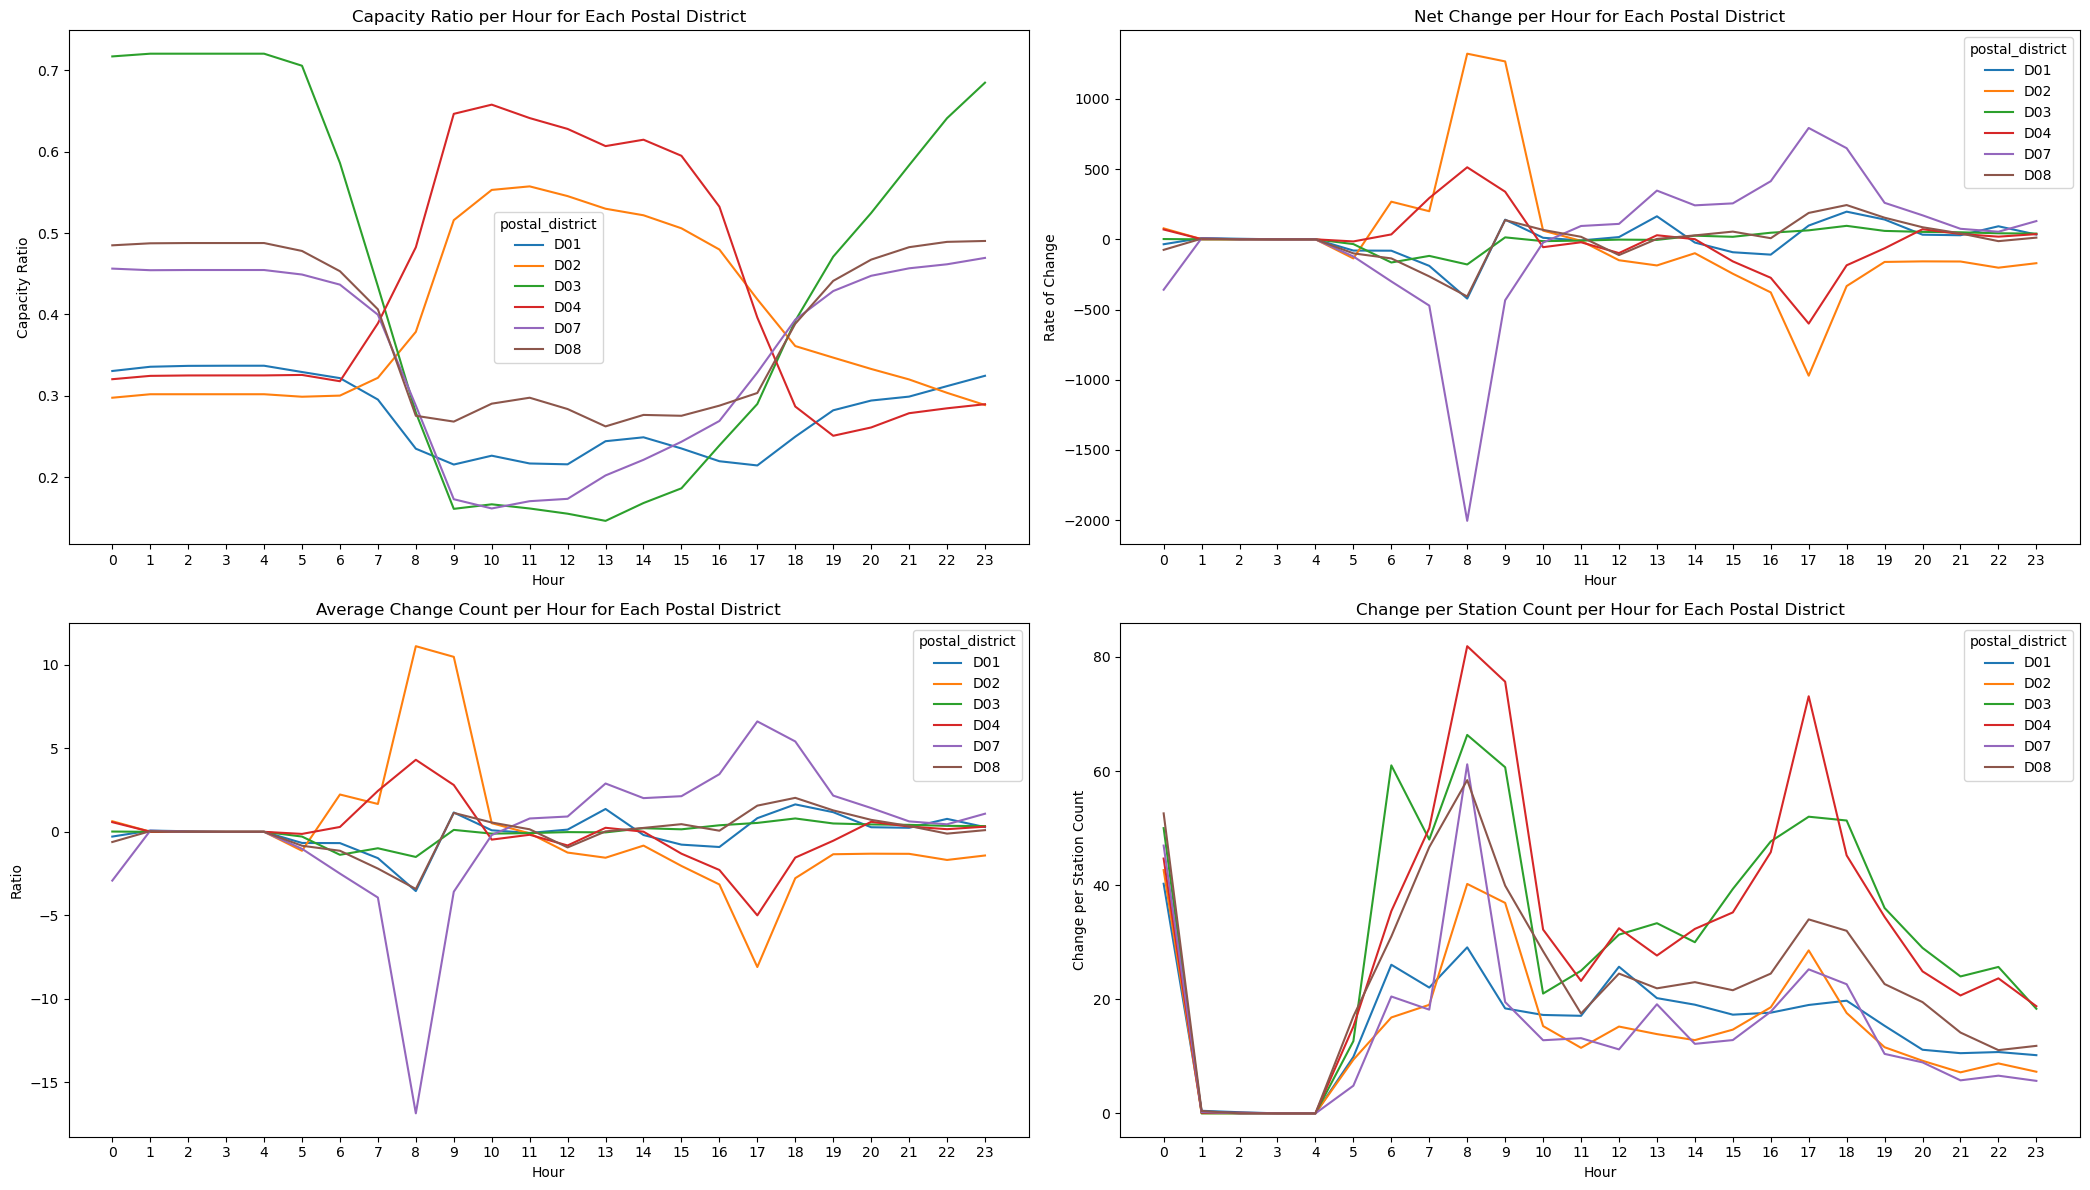

In [11]:
# Create a subset excluding 'Weekend' day type
# week_day_subset_df = subset_df[subset_df['day_type'] != 'Weekend']
#week_day_subset_df['rate_of_change_per_bike_stand'] = week_day_subset_df['rate_of_change'] / week_day_subset_df['bike_stands'] 

result_df = subset_df.groupby(['hour_ht', 'harvest_time', 'postal_district']).agg({
    'available_bikes': 'sum',
    'bike_stands': 'sum'
}).reset_index()


# Group by address and postal_district to get unique combinations
unique_stations_postal_address = df[['address', 'postal_district']].drop_duplicates()

# Merge the unique postal districts back to max_bike_stands_station
max_bike_stands_station = max_bike_stands_station.merge(unique_stations_postal_address, how='inner', on='address')

# Calculate the total bike stands for each postal district
bike_stands_district_total = max_bike_stands_station.groupby(['postal_district'])['bike_stands'].sum().reset_index()
bike_stands_district_total.rename(columns={'bike_stands': 'bike_stands_district_total'}, inplace=True)

# Merge the results with result_df
result_df = result_df.merge(bike_stands_district_total, on='postal_district', how='left')

count_stations_per_district = max_bike_stands_station.groupby(['postal_district'])['address'].nunique().reset_index()
count_stations_per_district
result_df = result_df.merge(count_stations_per_district, on='postal_district', how='left')


# Calculate rate of change
# Step 2: Sort by address and then by harvest_time in descending order
result_df.sort_values(by=['postal_district', 'harvest_time'], ascending=[True, False], inplace=True)
result_df['previous_available_bikes'] = result_df.groupby('postal_district')['available_bikes'].shift(-1)
result_df['rate_of_change'] = result_df['available_bikes'] - result_df['previous_available_bikes']
result_df['rate_of_change_abs'] = result_df['rate_of_change'].abs()




result_df_hour_agg = result_df.groupby(['hour_ht', 'postal_district']).agg({
    'available_bikes': 'sum',
    'rate_of_change': ['mean', 'sum'], 
    'rate_of_change_abs': ['mean', 'sum'],
    'previous_available_bikes': 'sum',
    'bike_stands_district_total': 'max',
    'bike_stands': 'sum',
    'address': 'max'
}).reset_index()

# Flatten multi-index columns if needed
result_df_hour_agg.columns = ['_'.join(col).rstrip('_') for col in result_df_hour_agg.columns.values]

#calcs
result_df_hour_agg['ratio'] = result_df_hour_agg['rate_of_change_mean'] / result_df_hour_agg['bike_stands_district_total_max']
result_df_hour_agg['ratio_abs'] = result_df_hour_agg['ratio'].abs()
result_df_hour_agg['capacity_ratio'] = result_df_hour_agg['available_bikes_sum'] / result_df_hour_agg['bike_stands_sum']
result_df_hour_agg['change_per_station_count'] = result_df_hour_agg['rate_of_change_sum'] / result_df_hour_agg['address_max']
result_df_hour_agg['change_per_station_count_abs'] = result_df_hour_agg['rate_of_change_abs_sum'] / result_df_hour_agg['address_max']

result_df_hour_agg = result_df_hour_agg.fillna(result_df_hour_agg.mean())


# Set up the subplot grid for four charts
fig, axes = plt.subplots(2, 2, figsize=(21, 12))

# Plot capacity_ratio
sns.lineplot(data=result_df_hour_agg, x='hour_ht', y='capacity_ratio', hue='postal_district', ax=axes[0, 0])
axes[0, 0].set_title('Capacity Ratio per Hour for Each Postal District')
axes[0, 0].set_ylabel('Capacity Ratio')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_xticks(list(range(0, 24)))

# Plot rate_of_change
sns.lineplot(data=result_df_hour_agg, x='hour_ht', y='rate_of_change_sum', hue='postal_district', ax=axes[0, 1])
axes[0, 1].set_title('Net Change per Hour for Each Postal District')
axes[0, 1].set_ylabel('Rate of Change')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_xticks(list(range(0, 24)))

# Plot ratio
sns.lineplot(data=result_df_hour_agg, x='hour_ht', y='rate_of_change_mean', hue='postal_district', ax=axes[1, 0])
axes[1, 0].set_title('Average Change Count per Hour for Each Postal District')
axes[1, 0].set_ylabel('Ratio')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_xticks(list(range(0, 24)))

# Plot change_per_station_count
sns.lineplot(data=result_df_hour_agg, x='hour_ht', y='change_per_station_count_abs', hue='postal_district', ax=axes[1, 1])
axes[1, 1].set_title('Change per Station Count per Hour for Each Postal District')
axes[1, 1].set_ylabel('Change per Station Count')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_xticks(list(range(0, 24)))

# Adjust the layout to prevent overlap and place the legend outside of the plots
fig.tight_layout()
handles, labels = axes[1, 1].get_legend_handles_labels()

# Manually set the labels for the legend
unique_postal_districts = result_df_hour_agg['postal_district'].unique()
fig.legend(handles=handles[1:], labels=unique_postal_districts, title='Postal District', loc='center right', bbox_to_anchor=(1.1, 0.5))

# Remove legends from individual plots to avoid repetition
for ax in axes.flat:
    ax.get_legend().remove()

plt.show()





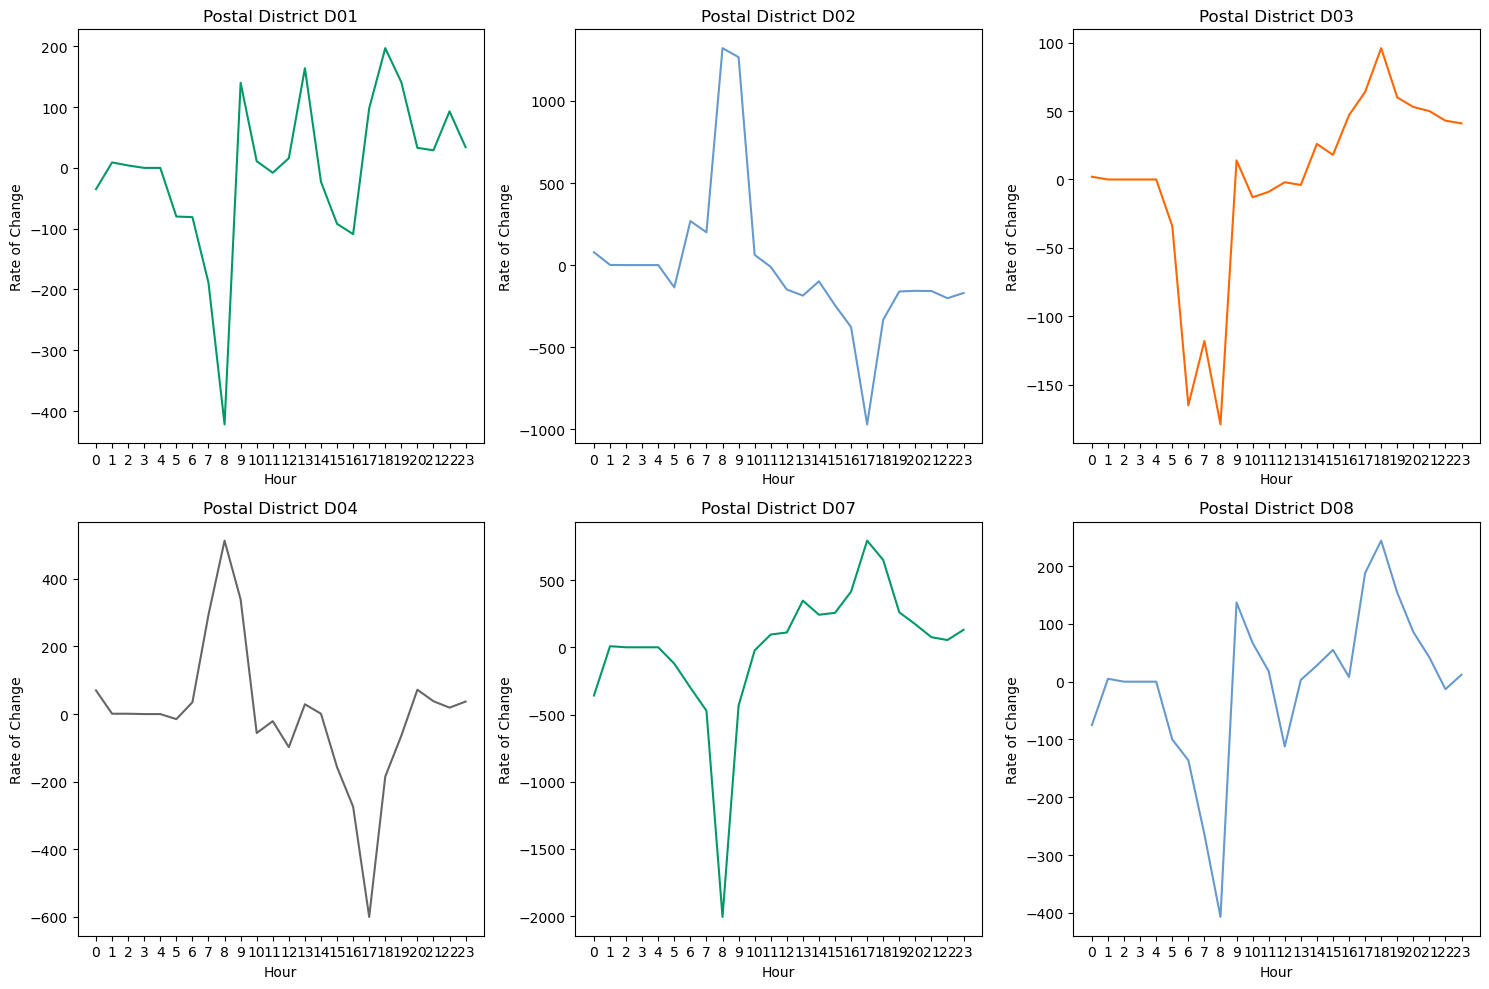

In [12]:
n_rows = 2
n_cols = 3

# Set up the plot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define color palette representing Dublin, Ireland
dublin_colors = ['#009966', '#6699cc', '#ff6600', '#666666']

# Plot time series for each postal district with Dublin colors
for i, postal_district in enumerate(unique_postal_districts):
    postal_data = result_df_hour_agg[result_df_hour_agg['postal_district'] == postal_district]
    color = dublin_colors[i % len(dublin_colors)]
    sns.lineplot(data=postal_data, x='hour_ht', y='rate_of_change_sum', ax=axes[i], color=color)
    axes[i].set_title(f'Postal District {postal_district}')
    axes[i].set_ylabel('Rate of Change')
    axes[i].set_xlabel('Hour')
    axes[i].set_xticks(list(range(0, 24)))

# Hide empty subplots
for i in range(len(unique_postal_districts), len(axes)):
    axes[i].axis('off')

# Adjust the layout to prevent overlap
fig.tight_layout()

plt.show()


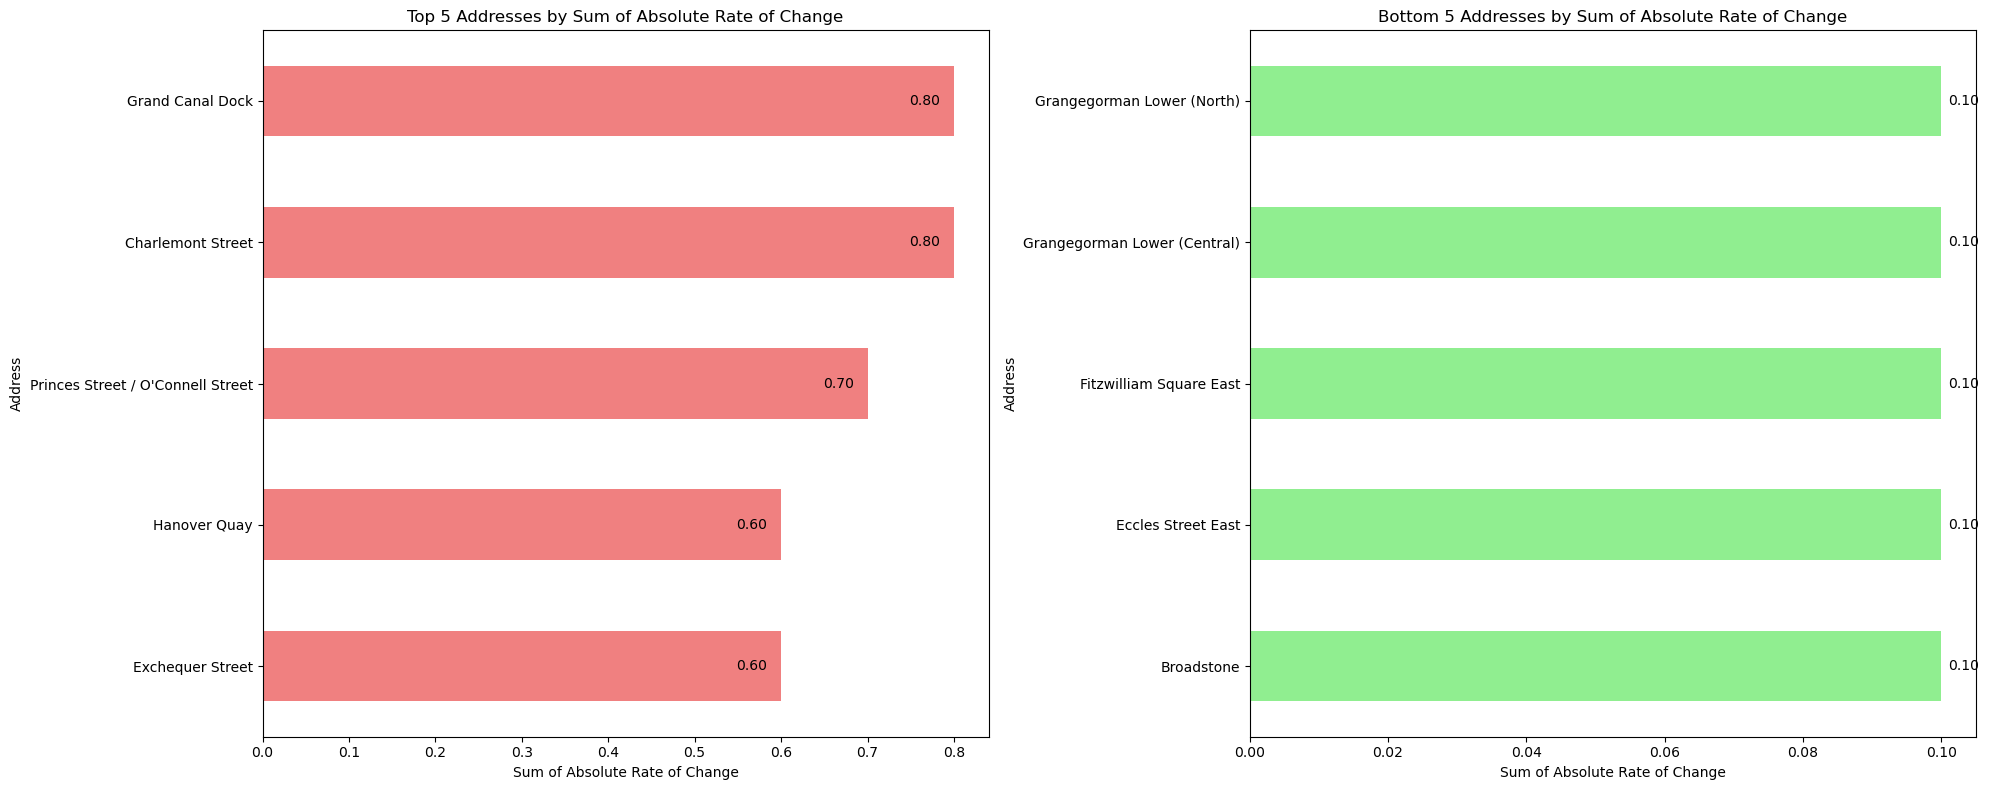

In [13]:
# Calculate the sum of absolute rate of change for each address
sum_rate_of_change_address = subset_df.groupby('address')['abs_rate_of_change'].mean() 
sum_rate_of_change_address = round(sum_rate_of_change_address, 1)

# Get the top 5 addresses by highest sum of absolute rate of change
top_5_addresses = sum_rate_of_change_address.nlargest(5)

# Get the bottom 5 addresses by least sum of absolute rate of change
bottom_5_addresses = sum_rate_of_change_address.nsmallest(5)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Top 5 Addresses with Highest Sum of Absolute Rate of Change
top_5_addresses.sort_values().plot(kind='barh', ax=ax1, color='lightcoral')
ax1.set_title('Top 5 Addresses by Sum of Absolute Rate of Change')
ax1.set_xlabel('Sum of Absolute Rate of Change')
ax1.set_ylabel('Address')

# Adding data labels on bars for the first plot
for bar in ax1.patches:
    ax1.text(bar.get_width() - (0.02 * top_5_addresses.max()),
             bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.2f}',  
             va='center', 
             ha='right',
             color='black')

# Bottom 5 Addresses with Least Sum of Absolute Rate of Change
bottom_5_addresses.sort_values().plot(kind='barh', ax=ax2, color='lightgreen')
ax2.set_title('Bottom 5 Addresses by Sum of Absolute Rate of Change')
ax2.set_xlabel('Sum of Absolute Rate of Change')
ax2.set_ylabel('Address')

# Adding data labels on bars for the second plot
for bar in ax2.patches:
    ax2.text(bar.get_width() + (0.01 * bottom_5_addresses.max()),  
             bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.2f}',  
             va='center', 
             ha='left',
             color='black')

plt.tight_layout()
plt.show()



In [14]:
# Calculate mean rate of change and mean capacity ratio for each address
rate_of_change_agg = subset_df.groupby('address').agg({
    'rate_of_change': ['mean', 'sum'], 
    'available_bikes': 'sum',
    'bike_stands': 'sum',
    'abs_rate_of_change': ['mean', 'sum'], 
    'bikes_added': 'sum',
    'bikes_removed': 'sum'
}).reset_index()

# Flatten multi-index columns if needed
rate_of_change_agg.columns = ['_'.join(col).rstrip('_') for col in rate_of_change_agg.columns.values]


rate_of_change_agg['cap_ratio'] = rate_of_change_agg['available_bikes_sum'] / rate_of_change_agg['bike_stands_sum']

max_bike_stands_station = max_bike_stands_station.rename(columns={'bike_stands': 'total_bike_stands'})
rate_of_change_agg = rate_of_change_agg.merge(max_bike_stands_station, on='address', how='left')

rate_of_change_agg['rate_of_change_per_bike_stand'] = rate_of_change_agg['rate_of_change_sum'] / rate_of_change_agg['total_bike_stands']

rate_of_change_agg['ratio_added_removed'] = rate_of_change_agg['bikes_added_sum'] / rate_of_change_agg['bikes_removed_sum']

# Normalize the data
scaler = StandardScaler()
rate_of_change_agg[['normalized_rate_change', 'abs_normalized_rate_change', 'normalized_cap_ratio', 'normalized_rate_of_change_per_bike_stand', 'normalized_ratio_added_removed', 'normalized_rate_of_change_mean', 'normalized_abs_rate_of_change_sum', 'normalized_abs_rate_of_change_mean']] = scaler.fit_transform(rate_of_change_agg[['rate_of_change_sum', 'abs_rate_of_change_sum', 'cap_ratio', 'rate_of_change_per_bike_stand', 'ratio_added_removed', 'rate_of_change_mean', 'abs_rate_of_change_sum', 'abs_rate_of_change_mean']])

# Apply k-means clustering
kmeans = KMeans(n_clusters=7)  
rate_of_change_agg['cluster'] = kmeans.fit_predict(rate_of_change_agg[['normalized_cap_ratio', 'normalized_abs_rate_of_change_mean']])

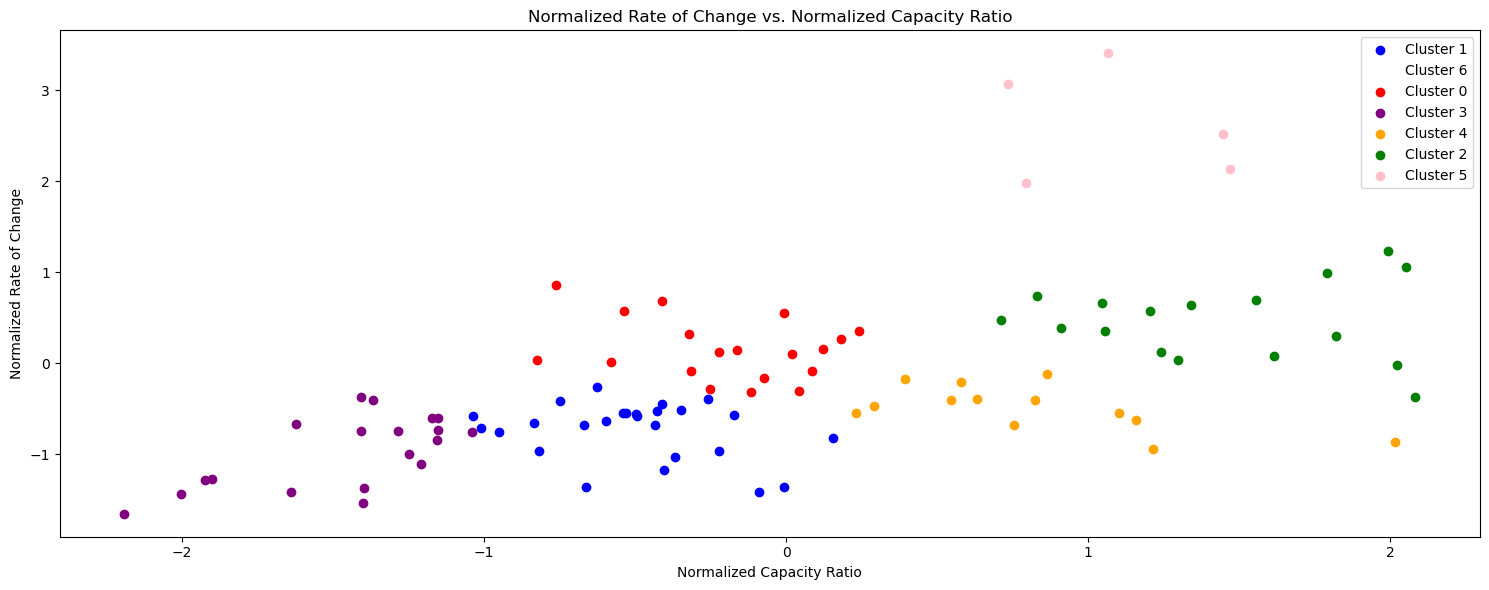

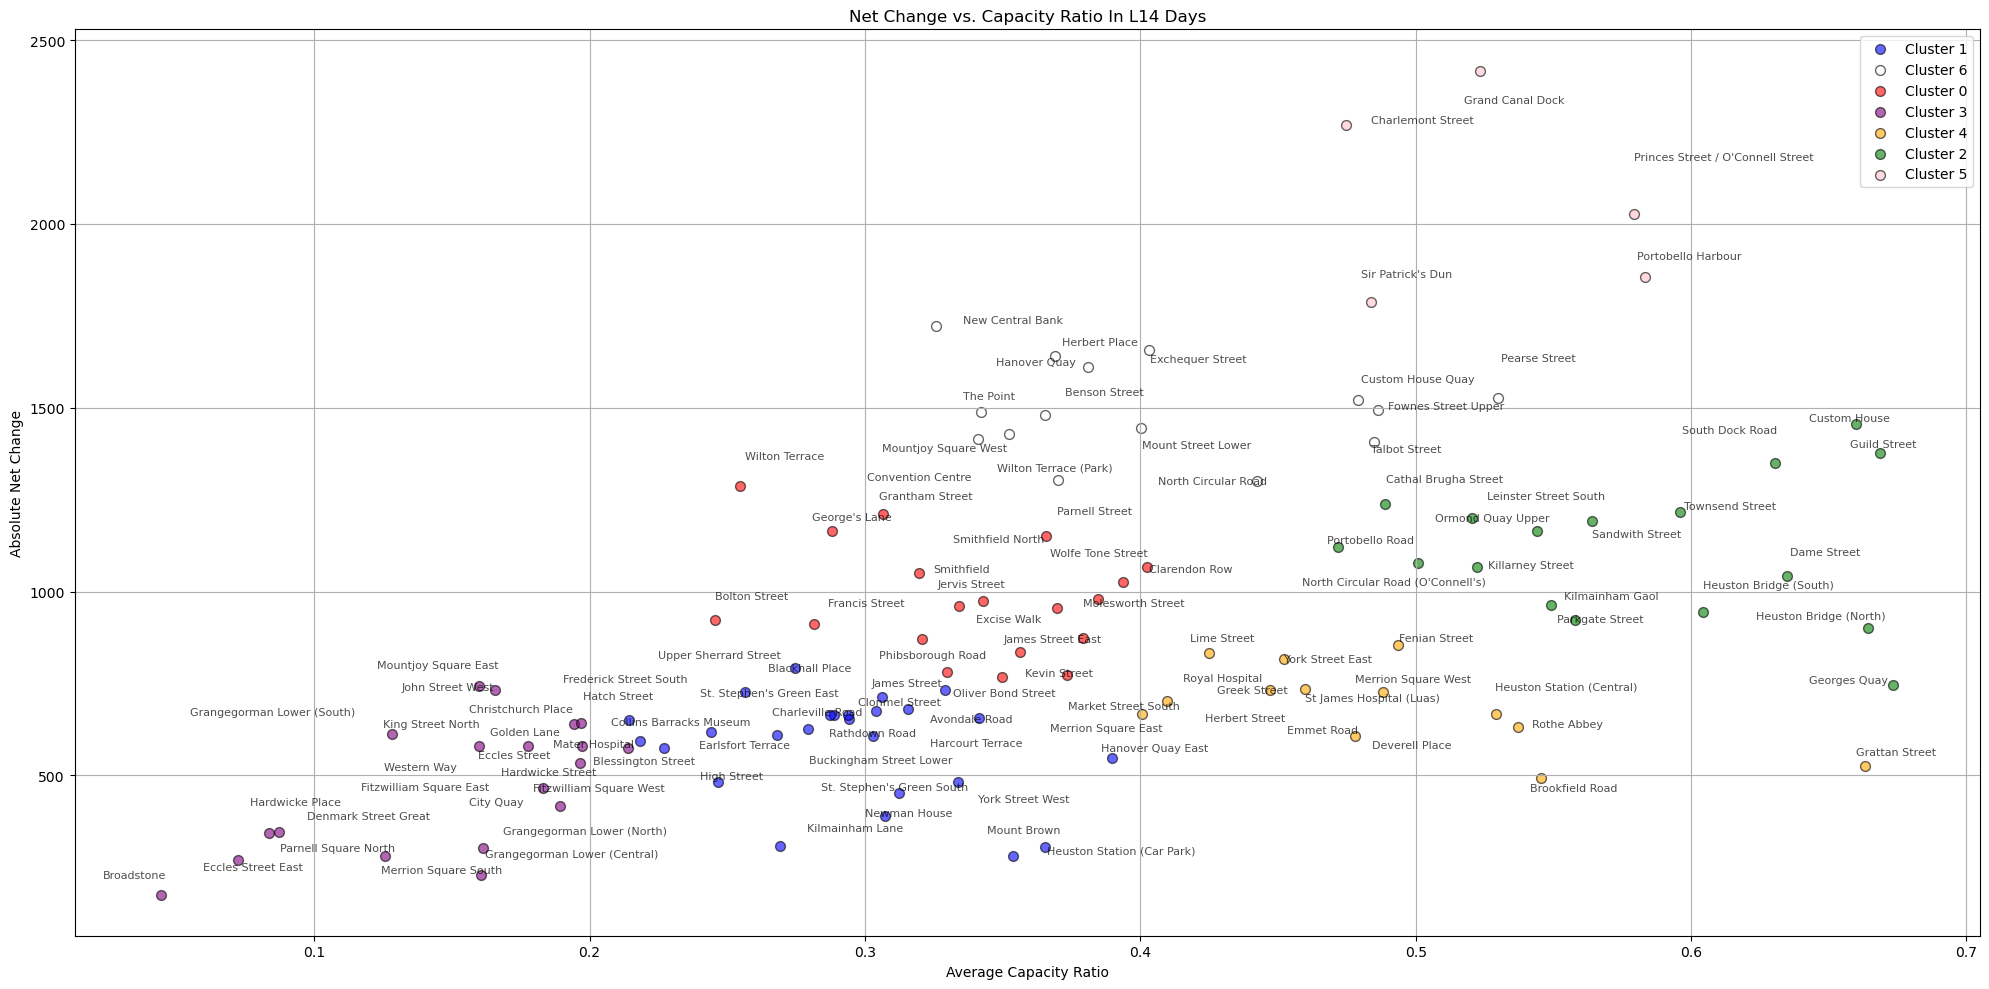

In [15]:
# Define a color mapping for clusters
cluster_colors = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'purple',
    4: 'orange',
    5: 'pink',
    6: 'white'
}


# Adjust the width by changing the figsize parameter
plt.figure(figsize=(15, 6))

# Looping through unique clusters
for cluster in rate_of_change_agg['cluster'].unique():
    subset = rate_of_change_agg[rate_of_change_agg['cluster'] == cluster]
    plt.scatter(subset['normalized_cap_ratio'], subset['normalized_abs_rate_of_change_mean'], 
                color=cluster_colors[cluster], label=f'Cluster {cluster}')

plt.title('Normalized Rate of Change vs. Normalized Capacity Ratio')
plt.xlabel('Normalized Capacity Ratio')
plt.ylabel('Normalized Rate of Change')
plt.legend()
plt.tight_layout()
plt.show()


# Increase figure size
plt.figure(figsize=(20, 10))

# Add jitter
def add_jitter(values, factor=0.01):
    return values + np.random.randn(len(values)) * factor

jittered_cap_ratio = add_jitter(rate_of_change_agg['cap_ratio'], 0.005)
jittered_abs_rate_of_change = add_jitter(rate_of_change_agg['abs_rate_of_change_sum'], 50)   # Adjusted factor

# Scatter plot with color-coding based on clusters
for cluster in rate_of_change_agg['cluster'].unique():
    subset = rate_of_change_agg[rate_of_change_agg['cluster'] == cluster]
    plt.scatter(subset['cap_ratio'], subset['abs_rate_of_change_sum'], 
                color=cluster_colors[cluster], label=f'Cluster {cluster}', alpha=0.6, edgecolors='k', s=50)

# Adding labels with jittered values
texts = []
for i, row in rate_of_change_agg.iterrows():
    texts.append(plt.text(jittered_cap_ratio[i], jittered_abs_rate_of_change[i], row['address'], fontsize=8, alpha=0.7))

# Use adjust_text to rearrange overlapping labels without arrows
adjust_text(texts, only_move={'points':'y', 'texts':'y'})

plt.title('Net Change vs. Capacity Ratio In L14 Days')
plt.xlabel('Average Capacity Ratio')
plt.ylabel('Absolute Net Change')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



In [16]:
def get_cluster_color(cluster):
    """Function to return color based on cluster number."""
    folium_colors = {
        0: 'red',
        1: 'blue',
        2: 'green',
        3: 'purple',
        4: 'orange',
        5: 'pink',
        6: 'white'
    }
    return folium_colors.get(cluster, 'gray')

# Group data by address to get the unique latitude and longitude values
grouped_data = subset_df.groupby(['address', 'latitude', 'longitude']).first().reset_index()
grouped_data = grouped_data.merge(rate_of_change_agg[['address', 'cluster', 'cap_ratio', 'abs_rate_of_change_mean']], on='address', how='left')

# grouped_data['rate_of_change_mean'] = round(grouped_data['rate_of_change_mean'], 2)
grouped_data['cap_ratio'] = round(grouped_data['cap_ratio'], 2)
grouped_data['abs_rate_of_change_mean'] = round(grouped_data['abs_rate_of_change_mean'], 2)

# Convert latitude and longitude to numeric
grouped_data['latitude'] = pd.to_numeric(grouped_data['latitude'], errors='coerce')
grouped_data['longitude'] = pd.to_numeric(grouped_data['longitude'], errors='coerce')

# Create a base map
m = folium.Map(location=[grouped_data['latitude'].mean(), grouped_data['longitude'].mean()], zoom_start=14)

# Add stations to the map
for _, row in grouped_data.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['address']} - Cluster: {row['cluster']} - Capacity Ratio: {row['cap_ratio']} - Average Change Rate {row['abs_rate_of_change_mean']}",
        icon=folium.Icon(color=get_cluster_color(row['cluster'])),
    ).add_to(m)

m


In [ ]:
subset_df['capacity_ratio'] = subset_df['available_bikes'] / subset_df['bike_stands']

In [17]:
# lets merge back now cluster
df = pd.merge(df, rate_of_change_agg[['address', 'cluster']], on='address', how='left')
subset_df = pd.merge(subset_df, rate_of_change_agg[['address', 'cluster']], on='address', how='left')


In [18]:
# Group by 'cluster'
grouped = subset_df.groupby('cluster')

# Aggregate the data
agg_data = grouped.agg(
    unique_addresses=pd.NamedAgg(column='address', aggfunc='nunique'),
    sum_available_bikes=pd.NamedAgg(column='available_bikes', aggfunc='sum'),
    sum_bike_stands=pd.NamedAgg(column='bike_stands', aggfunc='sum')
)

# Calculate capacity ratio
agg_data['capacity_ratio'] = agg_data['sum_available_bikes'] / agg_data['sum_bike_stands']

# Round capacity ratio to 2 decimal places
agg_data['capacity_ratio'] = agg_data['capacity_ratio'].round(2)

# Reset index to make 'cluster' a column instead of an index
agg_data.reset_index(inplace=True)

# Sort the data based on capacity ratio
agg_data = agg_data.sort_values(by='capacity_ratio', ascending=False)

#print
agg_data


,cluster,unique_addresses,sum_available_bikes,sum_bike_stands,capacity_ratio
2,2,17,847479,1462615,0.58
5,5,5,259449,498163,0.52
4,4,13,589874,1223420,0.48
6,6,15,603985,1508076,0.40
0,0,19,564445,1666922,0.34
1,1,26,727575,2464123,0.30
3,3,19,254789,1672903,0.15


In [19]:
# Group by postal district and cluster, and count unique addresses
unique_addresses_per_district_cluster = grouped_data.groupby(['postal_district', 'cluster'])['address'].nunique()

# Convert to a DataFrame
unique_addresses_per_district_cluster_df = unique_addresses_per_district_cluster.reset_index()

# Rename columns for clarity
unique_addresses_per_district_cluster_df.columns = ['Postal District', 'Cluster', 'Unique Addresses Count']

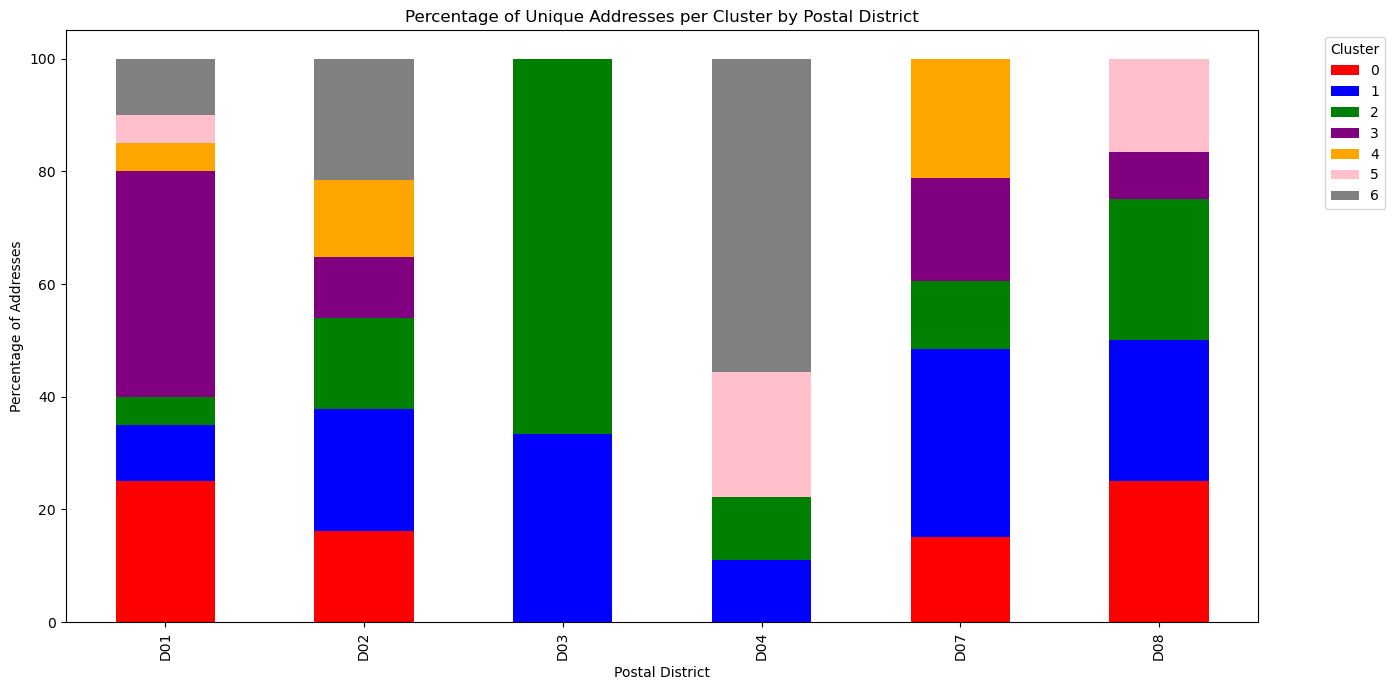

In [20]:
color_map = {
    0: 'red', 
    1: 'blue', 
    2: 'green', 
    3: 'purple', 
    4: 'orange', 
    5: 'pink', 
    6: 'grey'
}

# Calculate the total addresses per postal district.
total_addresses_per_district = unique_addresses_per_district_cluster_df.groupby('Postal District')['Unique Addresses Count'].sum().reset_index(name='Total')

# Merge with the original DataFrame to get the total addresses for each postal district.
merged_df = unique_addresses_per_district_cluster_df.merge(total_addresses_per_district, on='Postal District')

# Calculate the percentage of addresses for each cluster.
merged_df['Percentage'] = merged_df['Unique Addresses Count'] / merged_df['Total'] * 100

# Pivot the table to get percentages for each cluster by postal district.
pivot_df = merged_df.pivot(index='Postal District', columns='Cluster', values='Percentage').fillna(0)

# Sort the clusters to maintain consistent color ordering.
sorted_clusters = sorted(pivot_df.columns)

# Apply the color map to the sorted clusters.
cluster_colors = [color_map[cluster] for cluster in sorted_clusters if cluster in color_map]

# Plot the stacked bar chart.
pivot_df[sorted_clusters].plot(kind='bar', stacked=True, color=cluster_colors, figsize=(14, 7))

# Customize the plot.
plt.title('Percentage of Unique Addresses per Cluster by Postal District')
plt.xlabel('Postal District')
plt.ylabel('Percentage of Addresses')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot.
plt.show()
